In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from os import listdir
from os.path import join, isdir
import tensorflow as tf
from tensorflow.keras import layers, optimizers, Model, regularizers
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import seaborn as sns
from scipy.ndimage import rotate


np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def load_kaggle_data(data_dir, height, width, depth, max_person_ids=20, max_images_per_dir=15, max_pairs_per_person=50):
    X_base_list, X_comparison_list, y_list = [], [], []

    print(f"Scanning directory: {data_dir}")

    person_dirs = sorted([d for d in listdir(data_dir) if isdir(join(data_dir, d)) and not d.endswith('_forg')])[:max_person_ids]

    for person_id in person_dirs:
        real_dir = join(data_dir, person_id)
        forg_dir = join(data_dir, f"{person_id}_forg")

        real_images = []
        forg_images = []


        try:
            for file_name in sorted(listdir(real_dir))[:max_images_per_dir]:
                img_path = join(real_dir, file_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (width, height)).reshape((width, height, depth))
                    real_images.append(img)
        except FileNotFoundError:
            print(f"Error accessing files in {real_dir}")
            continue


        if isdir(forg_dir):
            try:
                for file_name in sorted(listdir(forg_dir))[:max_images_per_dir]:
                    img_path = join(forg_dir, file_name)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, (width, height)).reshape((width, height, depth))
                        forg_images.append(img)
            except FileNotFoundError:
                print(f"Error accessing files in {forg_dir}")
        else:
            print(f"Warning: Forged directory {forg_dir} not found")


        pair_count = 0
        genuine_pairs = 0
        forged_pairs = 0


        for i in range(len(real_images)):
            for j in range(i + 1, len(real_images)):
                if pair_count >= max_pairs_per_person or genuine_pairs >= max_pairs_per_person // 2:
                    break
                X_base_list.append(real_images[i])
                X_comparison_list.append(real_images[j])
                y_list.append(1)
                pair_count += 1
                genuine_pairs += 1


        for i in range(len(real_images)):
            for j in range(len(forg_images)):
                if pair_count >= max_pairs_per_person or forged_pairs >= max_pairs_per_person // 2:
                    break
                X_base_list.append(real_images[i])
                X_comparison_list.append(forg_images[j])
                y_list.append(0)
                pair_count += 1
                forged_pairs += 1

        genuine_count = np.sum(np.array(y_list[-pair_count:]) == 1)
        forged_count = np.sum(np.array(y_list[-pair_count:]) == 0)
        print(f"Processed {person_id}: {pair_count} pairs (Genuine: {genuine_count}, Forged: {forged_count})")


    if not X_base_list:
        raise ValueError("No valid image pairs found. Check dataset structure.")

    X_base = np.array(X_base_list)
    X_comparison = np.array(X_comparison_list)
    y = np.array(y_list)


    X_base = X_base / 255.0
    X_comparison = X_comparison / 255.0

    total_genuine = np.sum(y == 1)
    total_forged = np.sum(y == 0)
    print(f"Total loaded: {len(X_base)} pairs (Genuine: {total_genuine}, Forged: {total_forged})")
    return X_base, X_comparison, y

In [ ]:
def build_feature_extractor(width, height, depth):
    inputs = layers.Input(shape=(width, height, depth))
    x = layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    return Model(inputs, x)

def build_siamese_model(width, height, depth):
    x1 = layers.Input(shape=(width, height, depth))
    x2 = layers.Input(shape=(width, height, depth))
    feature_model = build_feature_extractor(width, height, depth)
    feat_x1 = feature_model(x1)
    feat_x2 = feature_model(x2)
    merged = layers.Subtract()([feat_x1, feat_x2])
    merged = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(merged)
    merged = layers.Dropout(0.5)(merged)
    output = layers.Dense(1, activation='sigmoid')(merged)
    return Model(inputs=[x1, x2], outputs=output)

In [ ]:
def train_model(classifier, X_base_train, X_comparison_train, y_train, X_base_test, X_comparison_test, y_test):
    classifier.compile(loss='binary_crossentropy',
                      optimizer=optimizers.Adam(learning_rate=0.00005),
                      metrics=['accuracy'])

    history = classifier.fit(
        [X_base_train, X_comparison_train], y_train,
        batch_size=32,
        epochs=7,
        validation_data=([X_base_test, X_comparison_test], y_test),
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)]
    )

    return history

def select_optimal_threshold(classifier, X_base_test, X_comparison_test, y_test):
    y_scores = classifier.predict([X_base_test, X_comparison_test]).flatten()
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    return y_scores, optimal_threshold

In [ ]:
def plot_training_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)


    ax2.plot(history.history['accuracy'], label='Train Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_roc_pr_curves(y_true, y_scores):

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)


    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


    ax1.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic')
    ax1.legend()
    ax1.grid(True)


    ax2.plot(recall, precision, label='PR curve')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, optimal_threshold):
    cm = confusion_matrix(y_true, (y_pred > optimal_threshold).astype(int))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
def apply_distortions(img):

    img = img.astype(np.float32)
    if img.max() > 1.0:
        img = img / 255.0


    blur_img = img.copy()
    noise_img = img.copy()
    rot_img = img.copy()


    blur_img = cv2.GaussianBlur(blur_img, (5, 5), 0)
    blur_img = np.clip(blur_img, 0, 1)


    noise = np.random.normal(0, 0.02, img.shape)
    noise_img = noise_img + noise
    noise_img = np.clip(noise_img, 0, 1)


    rot_img = rotate(rot_img, angle=15, reshape=False, mode='nearest')
    rot_img = np.clip(rot_img, 0, 1)


    distortions = {
        'blur': (blur_img * 255).astype(np.uint8),
        'noise': (noise_img * 255).astype(np.uint8),
        'rotated': (rot_img * 255).astype(np.uint8)
    }


    for name, dist_img in distortions.items():
        print(f"{name.capitalize()} image - Min: {dist_img.min()}, Max: {dist_img.max()}")

    return distortions

In [ ]:
def test_signature_pair(image_path1, image_path, label, classifier, optimal_threshold, width, height, use_distortions=False):
    img1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img1 is None or img2 is None:
        print(f"Error loading images: {image_path1}, {image_path}")
        return False

    img1 = cv2.resize(img1, (width, height)).reshape((1, width, height, 1)) / 255.0
    img2 = cv2.resize(img2, (width, height)).reshape((1, width, height, 1)) / 255.0


    score = classifier.predict([img1, img2])[0][0]
    print(f"Original - Prediction: {score:.4f} {'(Genuine)' if score > optimal_threshold else '(Forgery)'}")


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(img1.squeeze(), cmap='gray')
    ax1.set_title('Signature A')
    ax2.imshow(img2.squeeze(), cmap='gray')
    ax2.set_title('Signature B')
    plt.suptitle(f'Label: {label} | Score: {score:.4f} | Threshold: {optimal_threshold:.4f}')
    plt.tight_layout()
    plt.show()

    if use_distortions:

        distortions = apply_distortions(img2.squeeze())

        for dist_name, dist_img in distortions.items():
            dist_img = dist_img.reshape((1, width, height, 1)) / 255.0
            score = classifier.predict([img1, dist_img])[0][0]
            print(f"{dist_name.capitalize()} - Prediction: {score:.4f} {'(Genuine)' if score > optimal_threshold else '(Forgery)'}")

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
            ax1.imshow(img1.squeeze(), cmap='gray')
            ax1.set_title('Signature A')
            ax2.imshow(dist_img.squeeze(), cmap='gray')
            ax2.set_title(f'Signature B ({dist_name.capitalize()})')
            plt.suptitle(f'Label: {label} | Score: {score:.4f} | Threshold: {optimal_threshold:.4f}')
            plt.tight_layout()
            plt.show()

    return True

Scanning directory: drive/MyDrive/OOD_LAB3_DATA/kaggle/train
Processed 001: 50 pairs (Genuine: 25, Forged: 25)
Processed 002: 50 pairs (Genuine: 25, Forged: 25)
Processed 003: 50 pairs (Genuine: 25, Forged: 25)
Processed 004: 50 pairs (Genuine: 25, Forged: 25)
Processed 006: 50 pairs (Genuine: 25, Forged: 25)
Processed 009: 50 pairs (Genuine: 25, Forged: 25)
Processed 012: 50 pairs (Genuine: 25, Forged: 25)
Processed 013: 50 pairs (Genuine: 25, Forged: 25)
Processed 014: 50 pairs (Genuine: 25, Forged: 25)
Processed 015: 50 pairs (Genuine: 25, Forged: 25)
Processed 016: 50 pairs (Genuine: 25, Forged: 25)
Processed 017: 50 pairs (Genuine: 25, Forged: 25)
Processed 018: 50 pairs (Genuine: 25, Forged: 25)
Processed 019: 50 pairs (Genuine: 25, Forged: 25)
Processed 020: 50 pairs (Genuine: 25, Forged: 25)
Processed 021: 50 pairs (Genuine: 25, Forged: 25)
Processed 022: 50 pairs (Genuine: 25, Forged: 25)
Processed 023: 50 pairs (Genuine: 25, Forged: 25)
Processed 024: 50 pairs (Genuine: 25, F

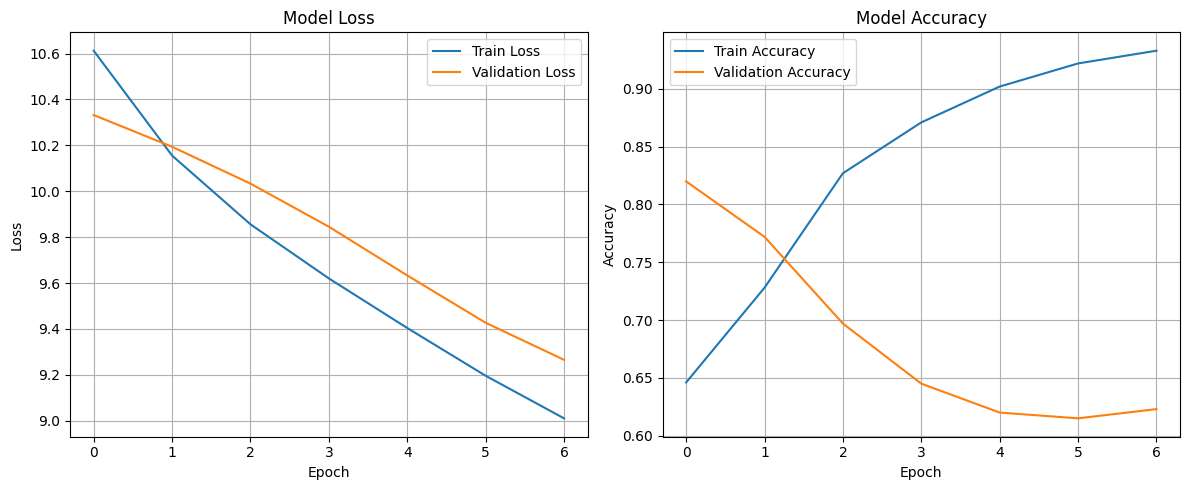

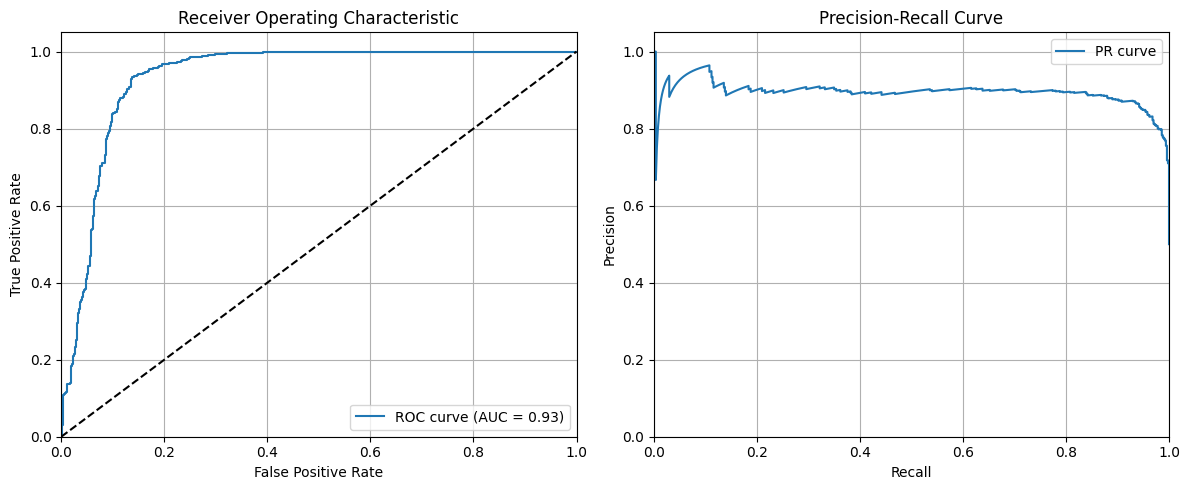

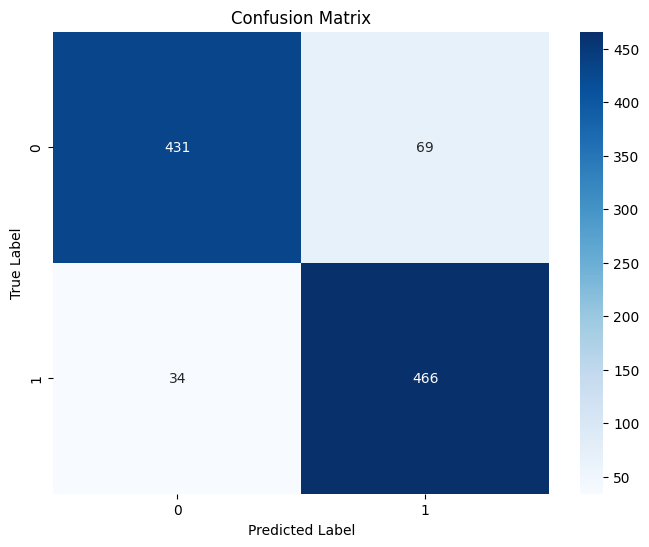

In [ ]:

height, width, depth = 100, 100, 1


train_dir = 'drive/MyDrive/OOD_LAB3_DATA/kaggle/train'
test_dir = 'drive/MyDrive/OOD_LAB3_DATA/kaggle/test'

try:
    X_base_train, X_comparison_train, y_train = load_kaggle_data(train_dir, height, width, depth)
    X_base_test, X_comparison_test, y_test = load_kaggle_data(test_dir, height, width, depth)
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please verify the dataset path and structure. Expected structure: <data_dir>/<person_id>/ for real signatures and <data_dir>/<person_id>_forg/ for forged signatures.")
    exit()


classifier = build_siamese_model(width, height, depth)
history = train_model(classifier, X_base_train, X_comparison_train, y_train, X_base_test, X_comparison_test, y_test)


y_scores, optimal_threshold = select_optimal_threshold(classifier, X_base_test, X_comparison_test, y_test)
print(f"Optimal threshold (F1-based): {optimal_threshold:.4f}")


plot_training_metrics(history)
plot_roc_pr_curves(y_test, y_scores)
plot_confusion_matrix(y_test, y_scores, optimal_threshold)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Original - Prediction: 0.4678 (Genuine)


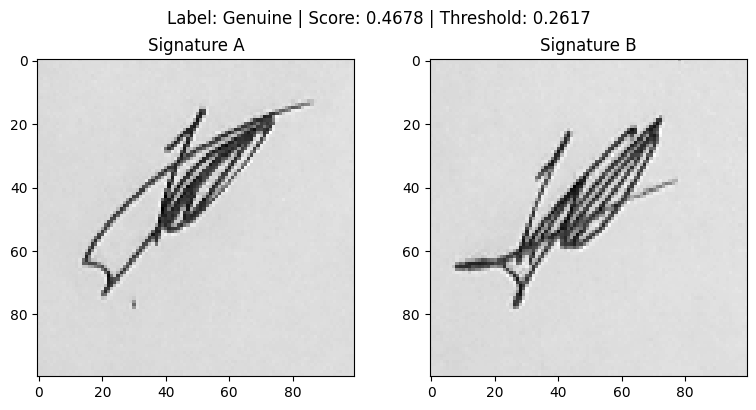

Blur image - Min: 88, Max: 200
Noise image - Min: 51, Max: 223
Rotated image - Min: 57, Max: 220
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Blur - Prediction: 0.5461 (Genuine)


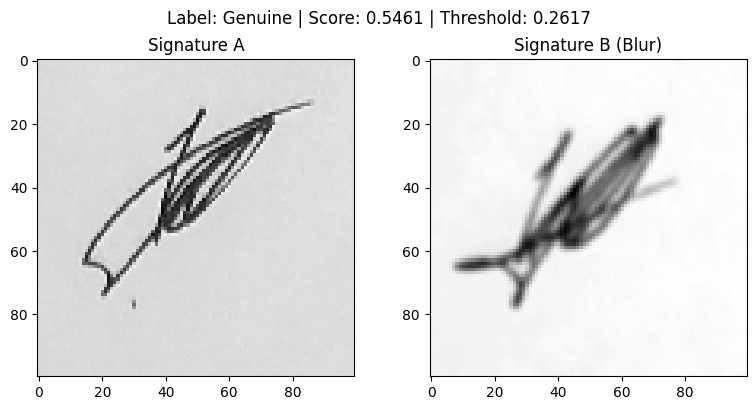

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Noise - Prediction: 0.4582 (Genuine)


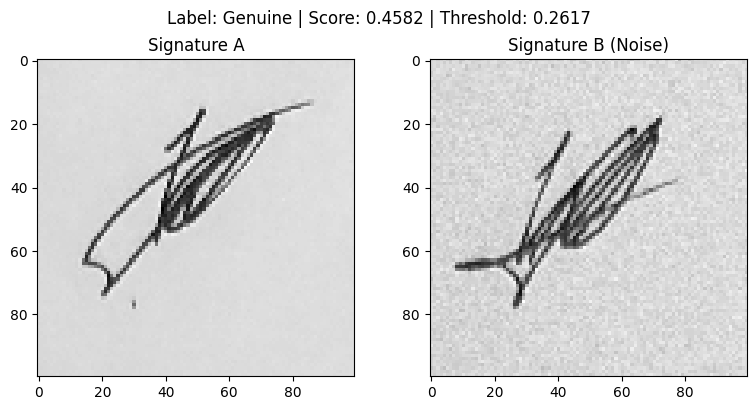

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Rotated - Prediction: 0.4752 (Genuine)


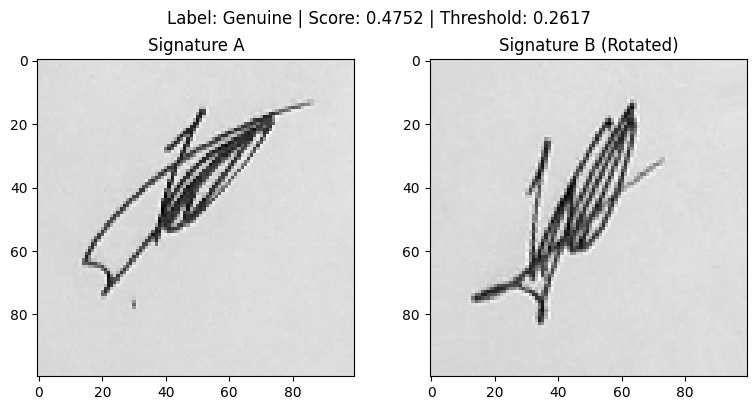

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Original - Prediction: 0.1163 (Forgery)


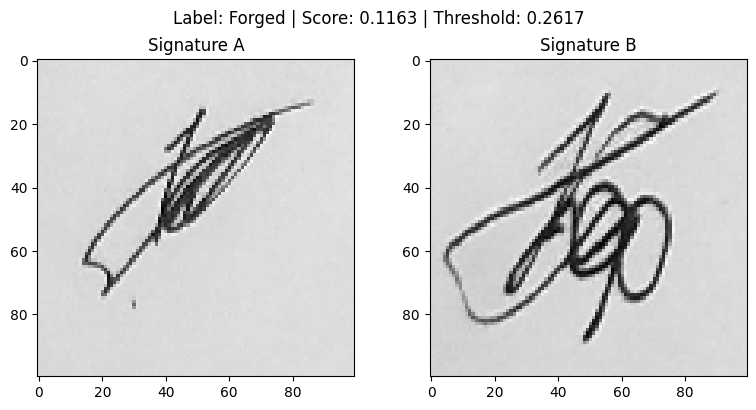

Blur image - Min: 33, Max: 156
Noise image - Min: 7, Max: 182
Rotated image - Min: 6, Max: 180
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Blur - Prediction: 0.2207 (Forgery)


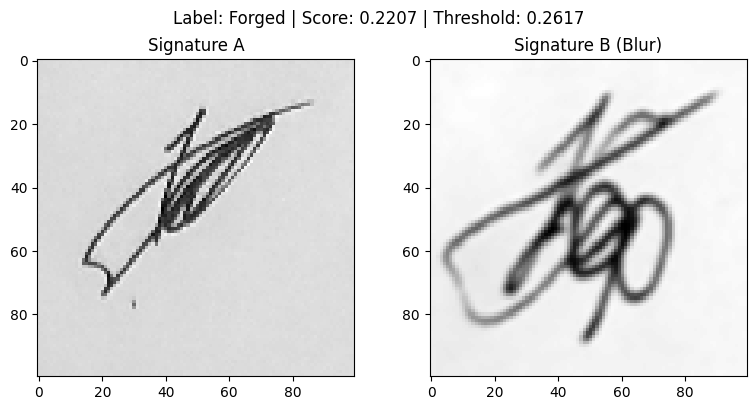

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Noise - Prediction: 0.1113 (Forgery)


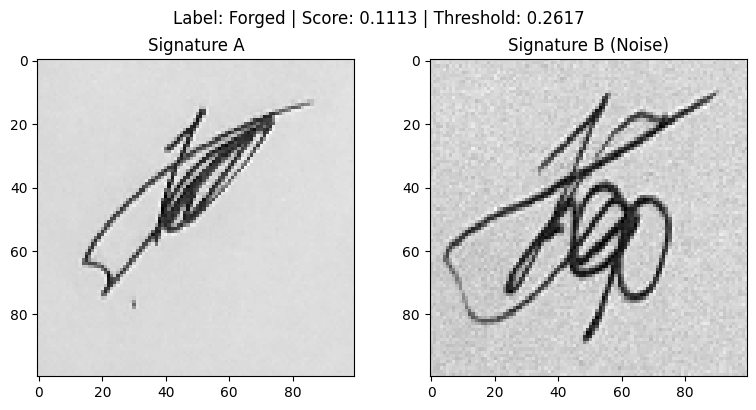

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Rotated - Prediction: 0.1237 (Forgery)


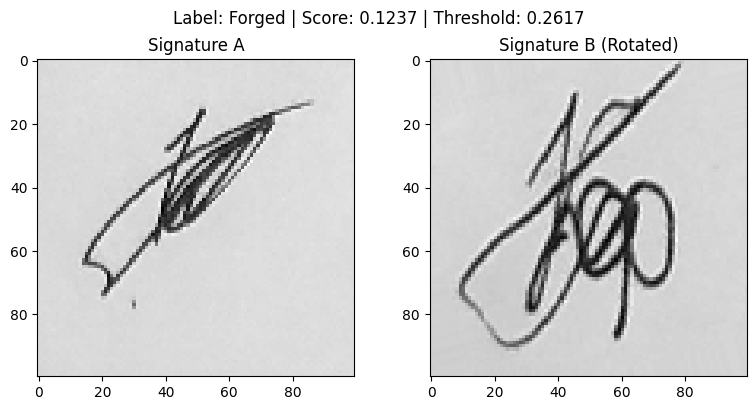

True

In [ ]:


test_signature_pair(
    image_path1='drive/MyDrive/OOD_LAB3_DATA/images/001/3.jpg',
    image_path='drive/MyDrive/OOD_LAB3_DATA/images/001/2.jpg',
    label='Genuine',
    classifier=classifier,
    optimal_threshold=optimal_threshold,
    width=width,
    height=height,
    use_distortions=True
)
test_signature_pair(
    image_path1='drive/MyDrive/OOD_LAB3_DATA/images/001/3.jpg',
    image_path='drive/MyDrive/OOD_LAB3_DATA/images/001_forg/1.jpg',
    label='Forged',
    classifier=classifier,
    optimal_threshold=optimal_threshold,
    width=width,
    height=height,
    use_distortions=True
)